In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [17]:
# Customer profile features
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['days_since_signup'] = (pd.Timestamp.now() - customers['SignupDate']).dt.days

# Transaction features
tx_features = transactions.groupby('CustomerID').agg({'TransactionID': 'count', 'TotalValue': ['sum', 'mean'], 'Quantity': ['sum', 'mean'],}).round(2)

# Flatten column names
tx_features.columns = ['transaction_count', 'total_spend', 'avg_transaction_value', 'total_quantity', 'avg_quantity'
]

# Calculate purchase frequency (transactions per day)
tx_features['purchase_frequency'] = tx_features['transaction_count']/customers.set_index('CustomerID')['days_since_signup']

# Add customer profile features
features = tx_features.join(pd.get_dummies(customers.set_index('CustomerID')['Region'],prefix='region'))

In [18]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, C0001 to C0200
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transaction_count      199 non-null    int64  
 1   total_spend            199 non-null    float64
 2   avg_transaction_value  199 non-null    float64
 3   total_quantity         199 non-null    int64  
 4   avg_quantity           199 non-null    float64
 5   purchase_frequency     199 non-null    float64
 6   region_Asia            199 non-null    uint8  
 7   region_Europe          199 non-null    uint8  
 8   region_North America   199 non-null    uint8  
 9   region_South America   199 non-null    uint8  
dtypes: float64(4), int64(2), uint8(4)
memory usage: 19.8+ KB


In [79]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [50]:
results = []
        
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate clustering metrics
    silhouette = silhouette_score(X_scaled, labels)
    calinski = calinski_harabasz_score(X_scaled, labels)
    db_index = davies_bouldin_score(X_scaled, labels)
    
    results.append({
        'n_clusters': k,
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'db_index': db_index,
        'inertia': kmeans.inertia_,
        'model': kmeans
    })

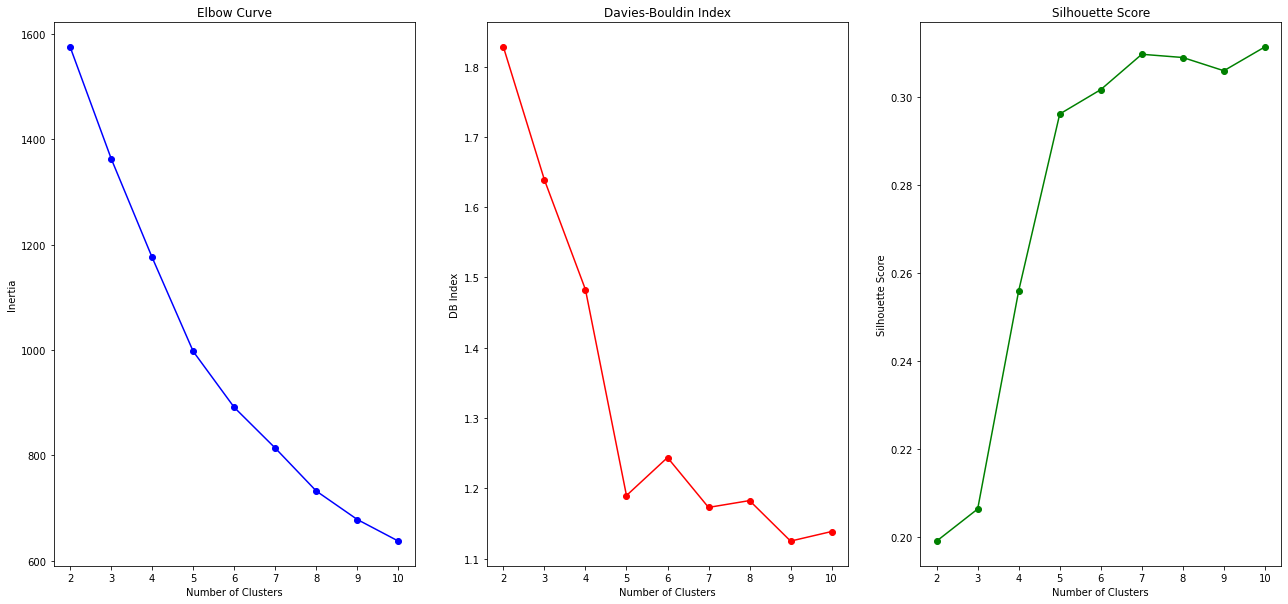

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(22, 10))
        
# Extract metrics
metrics = pd.DataFrame([{
    'n_clusters': r['n_clusters'],
    'silhouette': r['silhouette'],
    'calinski_harabasz': r['calinski_harabasz'],
    'db_index': r['db_index'],
    'inertia': r['inertia']
} for r in results])

# Plot 1: Elbow curve
axes[0].plot(metrics['n_clusters'], metrics['inertia'], 'bo-')
axes[0].set_title('Elbow Curve')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')

# Plot 2: DB Index
axes[1].plot(metrics['n_clusters'], metrics['db_index'], 'ro-')
axes[1].set_title('Davies-Bouldin Index')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('DB Index')

# Plot 3: Silhouette Score
axes[2].plot(metrics['n_clusters'], metrics['silhouette'], 'go-')
axes[2].set_title('Silhouette Score')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Silhouette Score')

plt.savefig('clustering_results.png', dpi=300, bbox_inches='tight')

By above graphs we can conclude that a clustering with 5 clusters is best suited.

In [68]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled)

KMeans(n_clusters=5)

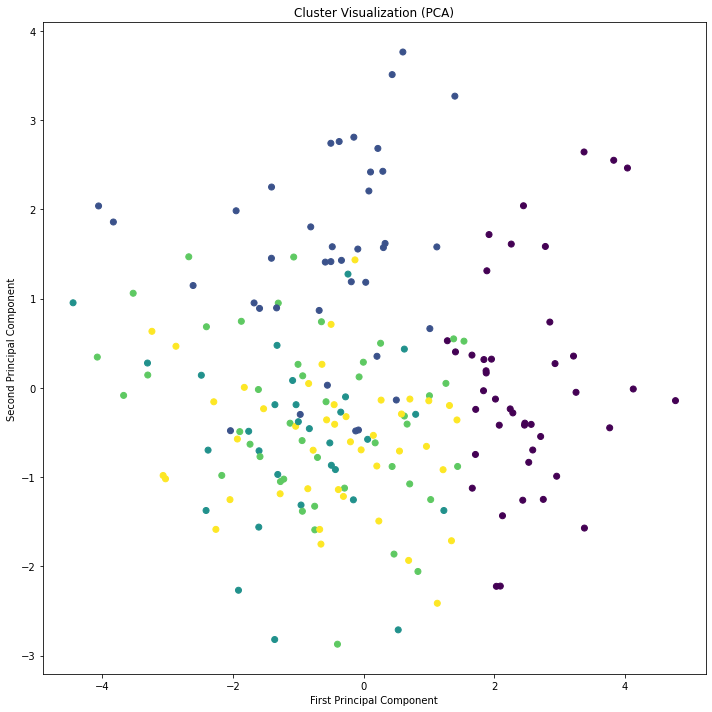

In [76]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.transform(features))

plt.figure(figsize=(10,10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                            c=kmeans.labels_, 
                            cmap='viridis')
plt.title('Cluster Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.tight_layout()
plt.savefig('clustering_results.png', dpi=300, bbox_inches='tight')

In [78]:
labels = kmeans.fit_predict(X_scaled)
    
# Calculate clustering metrics
silhouette = silhouette_score(X_scaled, labels)
calinski = calinski_harabasz_score(X_scaled, labels)
db_index = davies_bouldin_score(X_scaled, labels)

print(f'''Silhouette Score: {silhouette}
Calinski Harabasz Score: {calinski}
DB Index Value: {db_index}''')

Silhouette Score: 0.29666847183379863
Calinski Harabasz Score: 48.30399391888114
DB Index Value: 1.186083414442314
